# Yelp context analysis  
-NLP using Keras Pretrained Glove word Embeddings <br/>

Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem.

In [21]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
%matplotlib inline

#from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Input, Embedding, Activation

from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding


# Preparing text data

In [27]:
df = pd.read_csv("/Users/guapofish/Desktop/Yelp/data_cleaned.csv")
df.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,city,categories,state,sum_score,no_of_word,is_restaurant
0,dpfVRGN9BN-iY_l06TOJUg,5TCgTJE7uZ848zOEEUiVNg,DN0b4Un8--Uf6SEWLeh0UA,Good,2014-02-18,I refuse to judge a place before I try it and ...,92,952,43,Scottsdale,American (New);Pizza;Bakeries;Italian;Food;Res...,AZ,1087,789,True
1,DjAzP5k5sA9cudo39rsmcw,wuYbmgHqquyjjG3X4BYOeA,DN0b4Un8--Uf6SEWLeh0UA,Good,2012-11-18,ABC is fantastic every time. The food is consi...,17,932,11,Scottsdale,American (New);Pizza;Bakeries;Italian;Food;Res...,AZ,960,48,True
2,Yqh0TZhZt5fsBzFXD0q7bw,Zc5dh0i6c7TEPuhJqzuqOQ,DN0b4Un8--Uf6SEWLeh0UA,Good,2013-08-05,"WHY WE DECIDED TO GIVE THE PLACE A TRY:\nOk, s...",64,681,19,Scottsdale,American (New);Pizza;Bakeries;Italian;Food;Res...,AZ,764,646,True
3,WXD8zAnDF44gt6tcIGkrOg,NPwk91y2q7URU2VQJEQZMQ,DN0b4Un8--Uf6SEWLeh0UA,Good,2011-07-22,Breakfast at Amy's. It DOES NOT get any better...,14,611,5,Scottsdale,American (New);Pizza;Bakeries;Italian;Food;Res...,AZ,630,141,True
4,TyKxWlwMrjUW68I4R5x8xQ,NnMN10F4wDuBKv25vCqcCg,DN0b4Un8--Uf6SEWLeh0UA,Good,2009-10-05,For more than a year Amy's Baking Company has ...,31,589,10,Scottsdale,American (New);Pizza;Bakeries;Italian;Food;Res...,AZ,630,488,True


Variables: <br/>
1. review_id: the ID of customer <br/>
2. user_id: the ID of Yelp user<br/>
3. business_id: the ID of restaurant<br/>
4. stars: the star rated by customer<br/>
5. date: the date when reviews are made<br/>
6. text: the review from customer<br/>
7. useful: the number of Yelp user who thinks the review is useful<br/>
8. funny: the number of Yelp user who thinks the review is funny<br/>
9. cool: the number of Yelp user who thinks the review is cool<br/>
10. city: the city where restaurant locates<br/>
11. categories: the type of restaurant<br/>
12. state: the state where the restaurant locates<br/>
13. sum_score: total score the restaurant receives from customers<br/>
14. no_of_word: number of words in text (English review only)<br/>


In [42]:
#check if there is some missing values in the df, good then we can move forward:

print(df.isnull().any())
print("The num of row of the Yelp Review data frame is " +str(len(df)))

review_id        False
user_id          False
business_id      False
stars            False
date             False
text             False
useful           False
funny            False
cool             False
city             False
categories       False
state            False
sum_score        False
no_of_word       False
is_restaurant    False
dtype: bool
The num of row of the Yelp Review data frame is 75583


In [43]:
df.stars.unique()

array(['Good', 'Bad'], dtype=object)

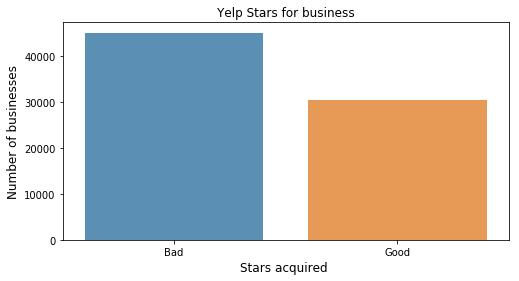

In [44]:
x = df['stars'].value_counts()
y = x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars acquired ', fontsize=12);

In [58]:
df["labels"]= df["stars"].apply(lambda x: 1 if 'Good' else 0)
df = df.drop("stars",axis=1)

In [64]:
texts = df["text"].values # len(texts) = 75583
labels = df["labels"].values

# Converting text into numerical representation i.e Tensors

To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [66]:
MAX_NUM_WORDS = 1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 100 # max number of words in a review to use

In [73]:
# from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts) # sequence_len = 75583
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 105465 unique tokens.


In [79]:
# from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (75583, 100)
Shape of label tensor: (75583, 2)


In [83]:
data[0]

array([  5,  88,   9, 429, 470,   2,  21,  39, 118,  18, 115,  20,  26,
       770,  18,  54,  13, 451,  18,  13,  24, 309,   4, 494, 265,   5,
        12,   3, 227,   8, 375,   5, 490, 120,   6, 273,   3, 451,  18,
       348,  11,  15, 528,   3, 142,  17,   1,  31, 399,  17, 101,   8,
         3, 178,  88, 583, 313,  15,  31,  10,  28,  41,  28,   8, 637,
         9,  16,   2,  16, 425,   2,   3,  70,  29,  59,  11, 718, 147,
         1, 769,  10,  64,  42, 219,  11,   4, 157, 522, 101,  11, 623,
        37, 422, 789,   5,  29,   4, 237,   6,   9], dtype=int32)

# Split the data into a training set and a validation set

In [84]:
VALIDATION_SPLIT=0.3

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices] # data[indices].shape = (75583, 100)
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0]) #22674

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

--- Preparing the Embedding layer

In [95]:
GLOVE_DIR='/Users/guapofish/Desktop/Yelp/'

#import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [102]:
embeddings_index['the'] #length = 50 

array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [104]:
embeddings_index['.'] #length = 50 

array([ 1.5164e-01,  3.0177e-01, -1.6763e-01,  1.7684e-01,  3.1719e-01,
        3.3973e-01, -4.3478e-01, -3.1086e-01, -4.4999e-01, -2.9486e-01,
        1.6608e-01,  1.1963e-01, -4.1328e-01, -4.2353e-01,  5.9868e-01,
        2.8825e-01, -1.1547e-01, -4.1848e-02, -6.7989e-01, -2.5063e-01,
        1.8472e-01,  8.6876e-02,  4.6582e-01,  1.5035e-02,  4.3474e-02,
       -1.4671e+00, -3.0384e-01, -2.3441e-02,  3.0589e-01, -2.1785e-01,
        3.7460e+00,  4.2284e-03, -1.8436e-01, -4.6209e-01,  9.8329e-02,
       -1.1907e-01,  2.3919e-01,  1.1610e-01,  4.1705e-01,  5.6763e-02,
       -6.3681e-05,  6.8987e-02,  8.7939e-02, -1.0285e-01, -1.3931e-01,
        2.2314e-01, -8.0803e-02, -3.5652e-01,  1.6413e-02,  1.0216e-01],
      dtype=float32)

In [110]:
EMBEDDING_DIM = 50 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [113]:
embedding_matrix.shape

(105466, 50)

In [114]:
#from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Train Model


First try the four layer DNN, see the # of layer is enough: <br/>
BidirectionalLSTMs -> MaxPool_1D -> Dense(Relu) -> Dense(Sigmoid)

In [136]:
#from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
#from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
#from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [137]:
#import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.9999):
            print("\nReached 99.99% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [138]:
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=5, batch_size=64, callbacks=[callbacks])

Train on 52909 samples, validate on 22674 samples
Epoch 1/5
52909/52909 [==============================] - 86s 2ms/step - loss: 0.0078 - acc: 0.9988 - val_loss: 1.5020e-07 - val_acc: 1.0000
Epoch 2/5
52909/52909 [==============================] - 85s 2ms/step - loss: 7.8655e-06 - acc: 1.0000 - val_loss: 1.1048e-07 - val_acc: 1.0000

Reached 99.99% accuracy so cancelling training!
